# March Madness

<!-- PELICAN_BEGIN_SUMMARY -->

This year I participated in [Kaggle's March Madness Competition](https://www.kaggle.com/c/mens-machine-learning-competition-2018). However, this isn't your typical office pool; instead participants are tasked with assigning every possible match-up in the field of 64 with a probability that a certain team will win.

In this post, I will describe my simple approach to building a machine learning model to predict winning percentages for March Madness games. Then, we'll see how it performed for this years competition!

Here's a sneak peak of my predicted bracket using machine learning...
<img src="http://jbechtel.github.io/images/predicted_bracket.png" alt='[img: bracket]'>


<!-- PELICAN_END_SUMMARY -->

## Introduction

The best part of the March Madness kaggle competition is the data. Kaggle proves formatted regular season stats, play-by-play data, Tourney match-ups and results plus more running back to 2003, and some data back to 1985. 

Unlike normal bracket challenges, Kaggle doesn't ask you to predict just the winner of each game. Instead they want the probability that a team will win. Furthermore, we have to predict win probabilities for every possible game, which for a $64$-slot bracket, can be calculated as $\sum_{i=1}^{64} (64-i)$, and comes to a grand total of $2016$ games. 

Submissions then comprise a $2016\times2$ vector where each row represents one of the possible matchups where the first column includes a string that defines a matchup such as `2016_North Carolina_Clemson`, and the second column represents the probability that the first team (UNC in this case) wins, which we call $y_p$. 




In [22]:
import pandas as pd
final_predictions = pd.read_csv('/Users/bechtel/Downloads/adv_stats_elo_predictions.csv')
df_teams = pd.read_csv('/Users/bechtel/Kaggle/NCAA_mens_tourney/Stage2/Teams.csv')
final_predictions.head()

,ID,Pred
0,2018_1104_1112,0.205233
1,2018_1104_1113,0.535824
2,2018_1104_1116,0.370760
3,2018_1104_1120,0.389872
4,2018_1104_1137,0.665728


In the final submission format the match-up ID involves team IDs as defined below

In [23]:
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


## Measuring Success


The measure of successful classification is judged as the [*log loss*](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html). This is defined as 

$$-\text{log} P(y_t|y_p) = -(y_t \text{log}(y_p) + (1 - y_t) \text{log}(1 - y_p))$$. 

When true, $y_t$ is 1, and $y_p$ is probability that $y_t$ is true. Hence if you predict an outcome $y_p=100\%$ and it turns out that the outcome is true $y_t=1$ then 
$$-\text{log} P(y_t|yp) = -1 * \text{log}(1.0) = 0$$.
Thus a perfect log loss score is 0. 

To get a better intuition of log loss let's remind ourselves of the shape of the log function. 

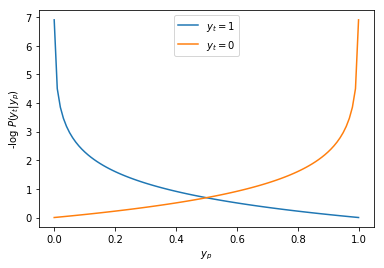

In [50]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0.001,0.999,100)
plt.plot(x,-np.log(x),label='$y_t=1$')
plt.plot(x,-np.log(1-x),label='$y_t=0$')
plt.xlabel('$y_p$')
plt.ylabel('-log $P(y_t|y_p)$')
plt.legend()
plt.show()

This plots the log loss of a prediction $y_p$ (x-axis) which is the probability that the outcome is true ($y_t=1$). Hence to find the log-loss given $y_p$ when the outcome is true, follow the blue curve. As expected the log loss is zero when our prediction of $y_p=100\%$ matches the outcome $y_p=1$. However, when the outcome is false ($y_t=0$), you can find the log-loss by following the orange curve.

As we can see, log-loss severely penalizes high probability mistakes. That is, if we predict a team wins with a 99% probability, and then they lose, the log-loss increases dramatically.

What happens if we assume that every game is a coin toss? I.e. the probability of a team winning is just 50%. 

Plugging into the formula: $-\text{log} P(y_t|yp) = -1 * \text{log}(0.5) = 0.6931$.

This sets a good baseline. If we build a model, it should at least predict winning percentages with a log-loss less than 0.6931, otherwise just assign 50% to every game...

## Building a Machine Learning Model

Now, given a boat load of data, how do we go about constructing a probabilistic classification model. [Sci-kit learn](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) provides a useful flow chart to aid in model selection:

<img src="http://jbechtel.github.io/images/ml_map.png" alt='[img: bracket]'>

First, this is a classification problem, so the techniques that we explored in the [last post](http://jonathonbechtel.com/blog/2018/02/06/wines/) are all at our disposal. 

Although, sci-kit learn doesn't include it in the flow chart, logistic regression is a useful model for classification problems. 

In particular fitting a logistic regression model corresponds to [minimizing the log loss](https://en.wikipedia.org/wiki/Logistic_regression#Model_fitting), which makes it a natural candidate. However, there are other possibilities such as neural nets, random forests, and support vector machines. 

## Feature Engineering


Before we settle on a classification algorithm, let's consider the feature space. That is, what data is the most important in determining a game's outcome. 

Brainstorming some possibilities:

1) Seed. We expect a 1-seed to defeat a 16-seed.  

   An obvious place to start is team Seed. One of the [kaggle starter kernels](https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-men-s-dataset) employs this strategy, and it performs reasonably well. However, since we have so much data, I think it makes sense to feed our model with more descriptors than just Seed.
      
      
2) Season Stats. A team that averages 70 points a game might defeat a 60 ppg team.
  
  There are many different stats in [basketball](https://stats.nba.com/help/glossary/). But some of the most predictive stats, so-called *Advanced Stats*, incorporate several statistics. Many of these advanced stats have been implemented by another [Kaggler in this notebook](https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stats), so we will use this as a starting point. However, since we are just interested in predicting Tourney results, we will use the season-averaged advanced stats, so we have a picture of a team's performance when heading into the March Madness. 
  
3) [Elo rating](https://en.wikipedia.org/wiki/Elo_rating_system). A team that has a 25-6 record against strong opponents should defeat a team with a 25-6 record against weak opponents. 

  The Elo rating was first devised as a chess ranking system, but has since spread to other sports and competitive games. Fortunately, the Elo ratings were also implemented in a Kaggle notebook [here](https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings), so we will calculate each Team's Elo rating at the end of the regular season. 

### Feature Vectors / Design Matrix

For each team we will concatentate a handful of season-averaged *Advanced Stats* and the team's *Elo* rating.

Then, the database of training data looks like:

In [62]:
# Example Training Data.
# Each Row
training_data = pd.read_csv('/Users/bechtel/Kaggle/NCAA_mens_tourney/training_data.csv')
training_data.head()

,TeamID,Season,WScore,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,...,LFTAR,WORP,LORP,WDRP,LDRP,WRP,LRP,WPIE,LPIE,SeasonELO
0,1101,2014,78.952381,62.809524,26.761905,53.000000,6.047619,16.190476,19.380952,26.476190,...,0.417375,0.327356,0.250436,0.749564,0.672644,0.548172,0.481404,0.705079,0.294921,1330.426954
1,1101,2015,74.892857,57.964286,26.285714,51.107143,7.392857,17.607143,14.928571,21.500000,...,0.313740,0.324596,0.254111,0.745889,0.675404,0.556259,0.446817,0.716104,0.283896,1215.475143
2,1101,2016,78.777778,67.333333,27.037037,54.074074,6.777778,16.851852,17.925926,24.148148,...,0.429980,0.276710,0.242496,0.757504,0.723290,0.530179,0.469067,0.624263,0.375737,1222.173273
3,1101,2017,74.320000,66.200000,24.840000,51.720000,7.360000,19.040000,17.280000,24.760000,...,0.332054,0.292514,0.253259,0.746741,0.707486,0.532922,0.470942,0.624039,0.375961,1238.537655
4,1102,2003,63.678571,50.571429,20.821429,39.571429,7.000000,15.607143,15.035714,21.928571,...,0.349808,0.287636,0.250215,0.749785,0.712364,0.541445,0.451335,0.730198,0.269802,1445.178904


Here, we see some of the stats that I used as descriptors. `WScore` is the average points scored among wins, while `LScore` is the average score in losses. Also, notice the last column which lists the team's SeasonELO rating for that season. 

A list of all of the training features is given below.

In [65]:
training_data.columns

Index(['TeamID', 'Season', 'WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3',
       'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk',
       'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WPts', 'LPts', 'Pos', 'WOffRtg',
       'LOffRtg', 'WDefRtg', 'LDefRtg', 'WNetRtg', 'LNetRtg', 'WAstR', 'LAstR',
       'WTOR', 'LTOR', 'WTSP', 'LTSP', 'WeFGP', 'LeFGP', 'WFTAR', 'LFTAR',
       'WORP', 'LORP', 'WDRP', 'LDRP', 'WRP', 'LRP', 'WPIE', 'LPIE',
       'SeasonELO'],
      dtype='object')

Hence each team has many descriptors for its regular season performace. Also note that `TeamID` and `Season` aren't actually part of the feature vector, they are just included to make it more readable. 

## Set up Classification Problem

Now how do we set up our labels and features for this classification problem?

We are going to be training on all of the past tournaments for which we have data. This includes the 2003-2017 seasons. 

For each Tourney game, we will describe it by the year, name of the first team: t1, and name of the second team: t2. The label describing the outcome is y, which equals 1 when the first team wins, and 0 if the second team wins. 

The feature vector, $x$, for this game is the difference of the first team's feature vector, $f_1$ and the second team's feature vector, $f_2$:

$$ \vec{x} = \vec{f_1} - \vec{f_2}.$$

Then we build our training data as a list of all of the $\vec{x}$'s, and the labels are the list of results, y. 

Just in case, we will also include all of the data where the names of the first and second team are switched. 



## Train Model

Now we can use any of our favorite classification algorithms to build our model. I tried several, and settled on logistic regresssion which naturally outputs probabilities that a certain example will result in a specified outcome.

### Logistic Regression, briefly. 

Essentially, logistic regression maps a feature space $x\in\mathbb{R}$ to a probability $\mathbf{P}(x)$ using a logistic function: 

$$ \mathbf{P}(x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}} $$

The parameters $\beta_0$ and $\beta_1$ are estimated while training the model. 

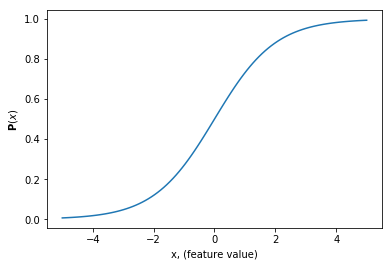

In [69]:
# plot logistic function
x = np.linspace(-5,5,100)
plt.plot(x,1./(1.+np.exp(-x)))
plt.ylabel('$\mathbf{P}(x)$')
plt.xlabel('x, (feature value)')
plt.show()

### Fitting and Validation

Of course, we want to avoid overfitting, so we use cross validation when training our model, and we also exhaustively search the space of hyperparameters to find their appropriate values using the `GridCV` function from sci-kit learn. 

In the end, I achieved log-losses around ~0.5 - 0.6 using logistic regression, which is at least better than assigning 50% probabilties to every game (log-loss 0.6931). 

In [72]:
# Results of cross-validated fitting scheme
# check out the github notebook for full details
df_results = pd.read_csv('/Users/bechtel/Kaggle/NCAA_mens_tourney/fitting_results.csv')
df_results

,classifier,train_score,test_score,training_time
0,Logistic Regression,0.519119,0.570086,0.539535
1,Gradient Boosting Classifier,0.484067,0.571517,1.592181
2,Decision Tree,0.521449,0.603861,0.354685


I thought this was decent for the amount of time I was willing to invest, so I trained my model with all available data from 2003-2017, then predicted the probabilistic outcomes for all possible 2018 matchups and uploaded the results to Kaggle!

## Track my Results

Then comes the exciting part... seeing how my model stacks up against the competition. Since this was my first Kaggle competition, I got pretty obsessed with checking my current standing in the leaderboard. While waiting for Kaggle to update the leaderboard, however, I simply inputed the games into my model so that I could at least track my personal log-loss score with up-to-date game results. The code for that can be found on [Kaggle](https://www.kaggle.com/drwonka/calculate-up-to-date-log-loss).

Other apps that allow you to visualize your predictions include an [html version](https://www.marksmath.org/visualization/kaggle_brackets/) and a [python module: bracketeer](https://github.com/cshaley/bracketeer) which is pictured on the top of the page.


Currently I am at least in the [top 50%](https://www.kaggle.com/c/mens-machine-learning-competition-2018/leaderboard), even after the tough Virginia loss. 

At the end of the tournament I'll update as to my final ranking, but currently I am 329/934. 


<img src="http://jbechtel.github.io/images/kaggle_ncaa_competition_ranking_before_championship.png" alt='[img: bracket]'>


## Concluding Remarks

Participating in this competition was a fun experience and I encourage any readers to enter it next year and also to explain your methodology in a blog post!

